# 予測値の期待値の信頼区間（R側からの補足）

[前提となる話](README.md)

0. 準備
1. **推奨**：線形正規回帰モデル（可視化のみ）
1. **推奨**：線形正規回帰モデル（理論的な結果）
1. 参考：線形正規回帰モデル（数式に基づく導出）
1. 参考：線形正規回帰モデル（ブートストラップ）
1. 参考：線形回帰モデル（ブートストラップ）


## 0. 準備

Rの`ggplot2::stat_smooth`とPythonの`seaborn.regplot`の違いが際立つように，誤差がxによるようなデータを作ります．ここでは，xが大きくなると誤差が大きくなるようにします．

In [1]:
library(boot)
library(tidyverse)

n <-  30
x <- 1:n
y <- 3 * x + 1 + rnorm(n, 0, 2 * x)
data <- data.frame(x = x, y = y)
#data %>% write_csv("1+3x+N(0,2x).csv") # 再利用のため

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
url <- "https://raw.githubusercontent.com/taroyabuki/fromzero/main/addendum/07.03.02/1%2B3x%2BN(0%2C2x).csv"
data <- read_csv(url)
x <- data$x
y <- data$y
n <- nrow(data)


── Column specification ────────────────────────────────────────────────────────
cols(
  x = col_double(),
  y = col_double()
)




## 1. 線形正規回帰モデル（可視化のみ）

`ggplot2::stat_smooth`で，予測値の期待値の信頼区間を描きます．この結果は，誤差についての仮定に基づく，理論的なものです．

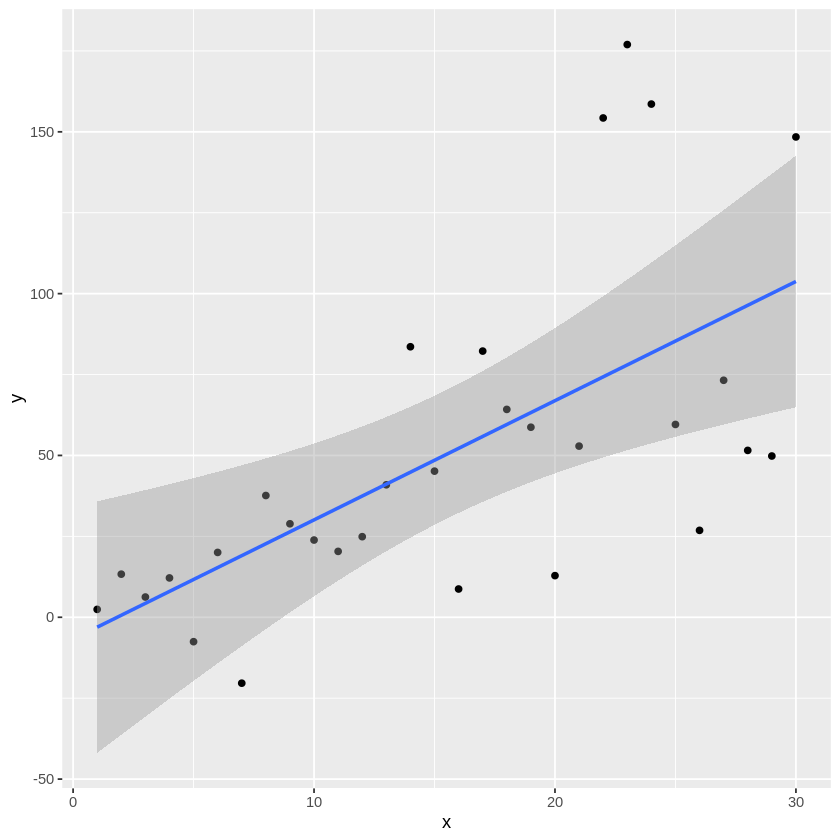

In [3]:
alpha <- 0.99
g <- data %>% ggplot(aes(x = x, y = y)) +
  geom_point() +
  stat_smooth(formula = y ~ x, method = "lm", level = alpha)
g

## 2. 線形正規回帰モデル（理論的な結果）

`predict`に引数`interval = 'confidence'`を与えて，1の結果の数値を得ます．

,fit,lwr,upr,x
,<chr>,<chr>,<chr>,<chr>
1,-3.06,-41.94,35.82,1
2,-1.98,-40.28,36.32,1.29
3,-0.9,-38.63,36.83,1.59
4,0.18,-36.98,37.34,1.88
...,...,...,...,...
97,100.53,63.37,137.69,29.12
98,101.61,63.88,139.34,29.41
99,102.69,64.38,140.99,29.71
100,103.76,64.88,142.65,30


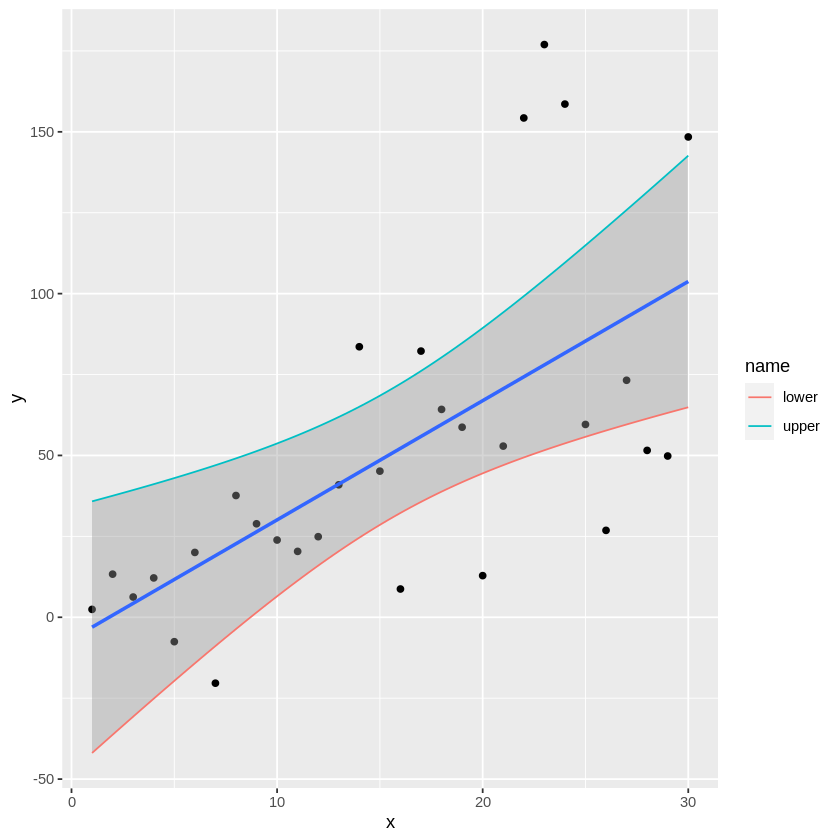

In [4]:
m <- 100
x0 <- seq(min(x), max(x), length.out = m)
X0 <- data.frame(x = x0)

ci2 <- lm(y ~ x) %>%
  predict(newdata = X0, interval = 'confidence', level = alpha) %>%
  as.data.frame %>% mutate(x = X0$x)
result <- ci2 %>% select(x, lower = lwr, upper = upr) %>% pivot_longer(-x)
psych::headTail(ci2)

g + geom_line(data = result,
              aes(x = x, y = value, color = name))

## 3. 線形正規回帰モデル（数式に基づく導出）

数式（文献[2]の式5.69）に基づいて，2の結果を再現します．

,x,delta_lower,delta_upper
,<chr>,<chr>,<chr>
1,1,0,0
2,1.29,0,0
3,1.59,0,0
4,1.88,0,0
...,...,...,...
97,29.12,0,0
98,29.41,0,0
99,29.71,0,0
100,30,0,0


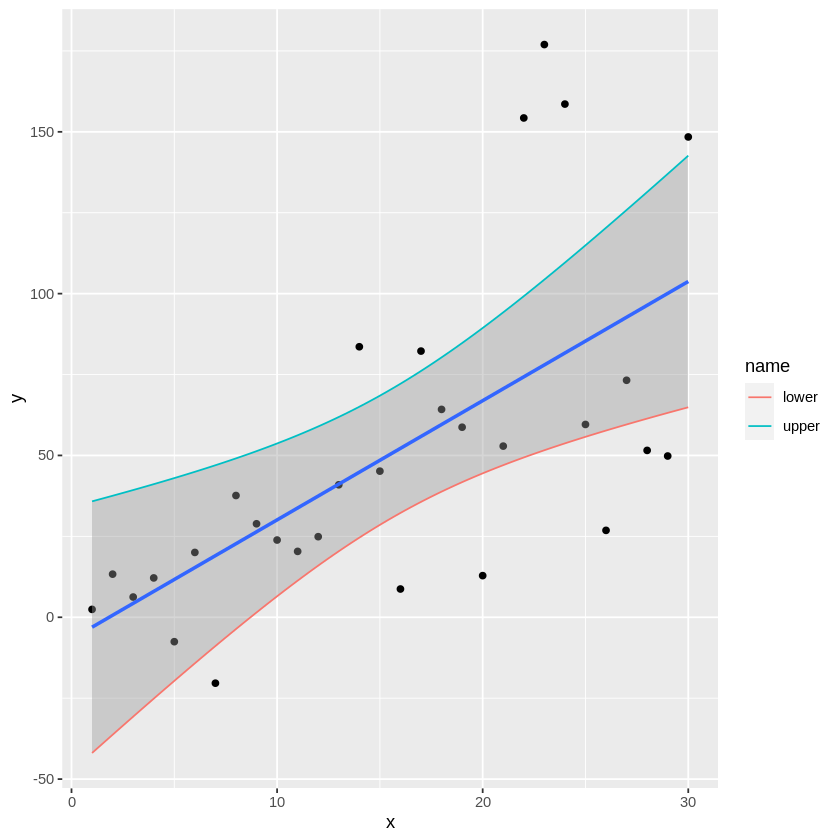

In [5]:
X <- cbind(rep(1,n), x) # 行列
b <- MASS::ginv(X) %*% y
yh <- X %*% b
e <- y - yh
p <- 2
s <- (sum(e * e) / (n - p))**0.5
M <- cbind(rep(1, m), x0)

f1 <- M %*% b
f2 <- s * qt((1 - alpha) / 2, n - p) *
  diag(M %*% solve(t(X) %*% X) %*% t(M))^0.5

ci3 <- data.frame(x = x0, lower = f1 + f2, upper = f1 - f2)
result <- ci3 %>% pivot_longer(-x)
tmp <- data.frame(x = x0,
                  delta_lower = ci3$lower - ci2$lwr,
                  delta_upper = ci3$upper - ci2$upr)
psych::headTail(tmp)

g + geom_line(data = result, aes(x = x, y = value, color = name))

## 4. 線形正規回帰モデル（ブートストラップ）

文献[1]のアルゴリズム6.1を使って，3や4の結果をブートストラップで再現します．

1. 回帰係数 $\hat{\beta}_0, \hat{\beta}_1$ を求める．
1. 中心化した修正済みの残差から $\epsilon^*_1,\dots,\epsilon^*_n$ を復元抽出する．
1. ブートストラップ標本 $Y^*_i=\hat{\beta}_0+\hat{\beta}_0x_i+\epsilon^*_i$（$i=1,\dots,n$）を作り，$(x_i, Y^*_i)$ にフィットする直線から，予測値を求める．
1. 大量に求めた予測値の，$100(1\pm\alpha)/2$ パーセント点を，信頼区間とする．

2や3で理論的に求めたものと，だいたい同じ結果になります．

,x,delta_lower,delta_upper
,<chr>,<chr>,<chr>
1,1,4.53,0.05
2,1.29,4.47,0.07
3,1.59,4.41,0.08
4,1.88,4.65,0.06
...,...,...,...
97,29.12,4.3,0.09
98,29.41,4.26,0.05
99,29.71,4.24,0.01
100,30,4.21,-0.04


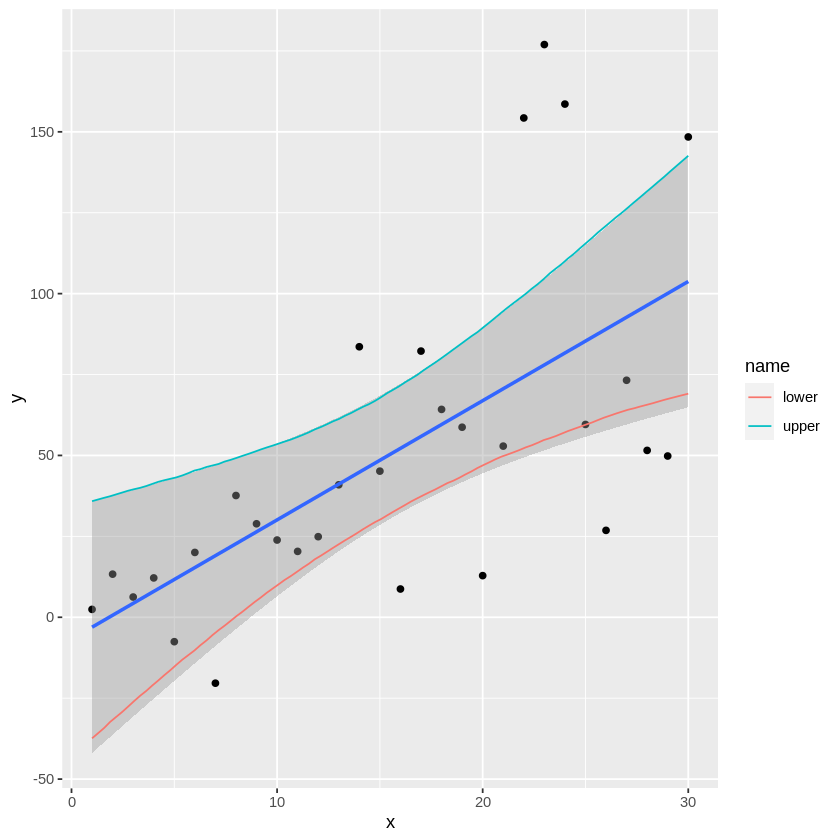

In [6]:
Sxx <- sum((x - mean(x))^2)
r <- e / sqrt(1 - 1 / n - (x - mean(x))^2 / Sxx)
r <- r - mean(r)

f <- function(X, i) {
  e_s <- X[i]
  y <- yh + e_s
  lm(y ~ x) %>% predict(X0)
}

n_boot <- 10000
boot.result <- boot(data = r, statistic = f, R = n_boot)

get_ci <- function(i) {
  tmp <- boot.ci(boot.result, type = "perc", index = i, conf = alpha)
  list(x = x0[i], lower = tmp$percent[4], upper = tmp$percent[5])
  #tmp <- boot.ci(boot.result, type = "bca", index = i, conf = alpha)
  #list(x = x0[i], lower = tmp$bca[4], upper = tmp$bca[5])
}

ci4 <- 1:m %>% map_dfr(get_ci)
result <- ci4 %>% pivot_longer(-x)
tmp <- data.frame(x = x0,
                  delta_lower = ci4$lower - ci2$lwr,
                  delta_upper = ci4$upper - ci2$upr)
psych::headTail(tmp)

g + geom_line(data = result, aes(x = x, y = value, color = name))

## 5. 線形回帰モデル（ブートストラップ）

Pythonの`seaborn.regplot`の結果を再現するために，文献[1]のアルゴリズム6.2を使います．

1. $(x_i, y_i)$ を復元抽出してブートストラップ標本を作り，それにフィットする直線から，予測値を求める．
1. 大量に求めた予測値の，$100(1\pm\alpha)/2$ パーセント点を，信頼区間とする．

Pythonの`seaborn.regplot`と，だいたい同じ結果になります．

x,lower,upper
<chr>,<chr>,<chr>
1,-27.82,16.51
1.29,-26.38,17.18
1.59,-24.86,17.87
1.88,-23.01,18.57
...,...,...
29.12,60.79,151.16
29.41,61.29,152.88
29.71,61.87,154.67
30,62.4,156.54


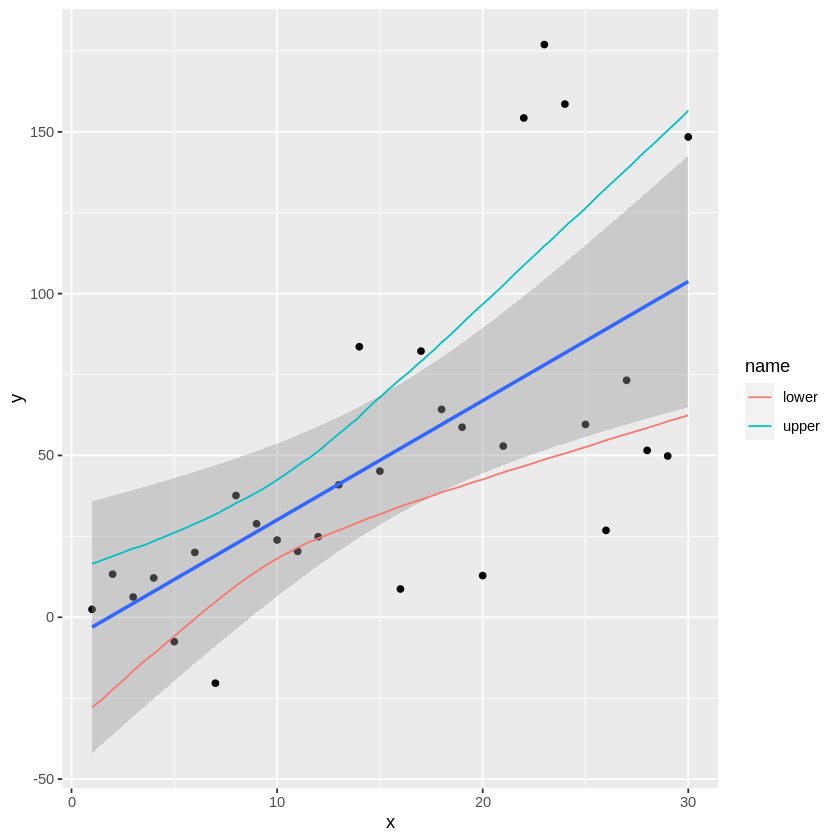

In [7]:
f <- function(X, i) {
  x <- X[i,]$x
  y <- X[i,]$y
  lm(y ~ x) %>% predict(X0)
}

boot.result <- boot(data = data, statistic = f, R = n_boot)
ci5 <- 1:m %>% map_dfr(get_ci)
result <- ci5 %>% pivot_longer(-x)
psych::headTail(ci5)

g + geom_line(data = result, aes(x = x, y = value, color = name))

## 参考文献

1. 汪金芳, 桜井裕仁. ブートストラップ入門. 共立出版, 2011.
1. 佐和隆光. 回帰分析. 朝倉書店, 新装版, 2020.